In [1]:
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from pymc.distributions.continuous import Exponential
from sklearn.preprocessing import StandardScaler
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
data_path = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/smoking.csv"

raw_data_df = pd.read_csv(data_path, parse_dates=["year"])

raw_data_df.head()


,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
0,1,1970-01-01,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,1,1971-01-01,95.400002,NaN,NaN,0.179928,42.700001,False,False
2,1,1972-01-01,101.099998,9.498476,NaN,0.180994,42.299999,False,False
3,1,1973-01-01,102.900002,9.550107,NaN,0.182060,42.099998,False,False
4,1,1974-01-01,108.199997,9.537163,NaN,0.183126,43.099998,False,False


In [3]:
df = raw_data_df.copy().drop(columns=["lnincome", "beer", "age15to24"]).assign()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   state            1209 non-null   int64         
 1   year             1209 non-null   datetime64[ns]
 2   cigsale          1209 non-null   float64       
 3   retprice         1209 non-null   float64       
 4   california       1209 non-null   bool          
 5   after_treatment  1209 non-null   bool          
dtypes: bool(2), datetime64[ns](1), float64(2), int64(1)
memory usage: 40.3 KB


[Text(0.5, 1.0, 'Gap in per-capita cigarette sales (in packs)'), Text(0, 0.5, 'Cigarette Sales Trend')]

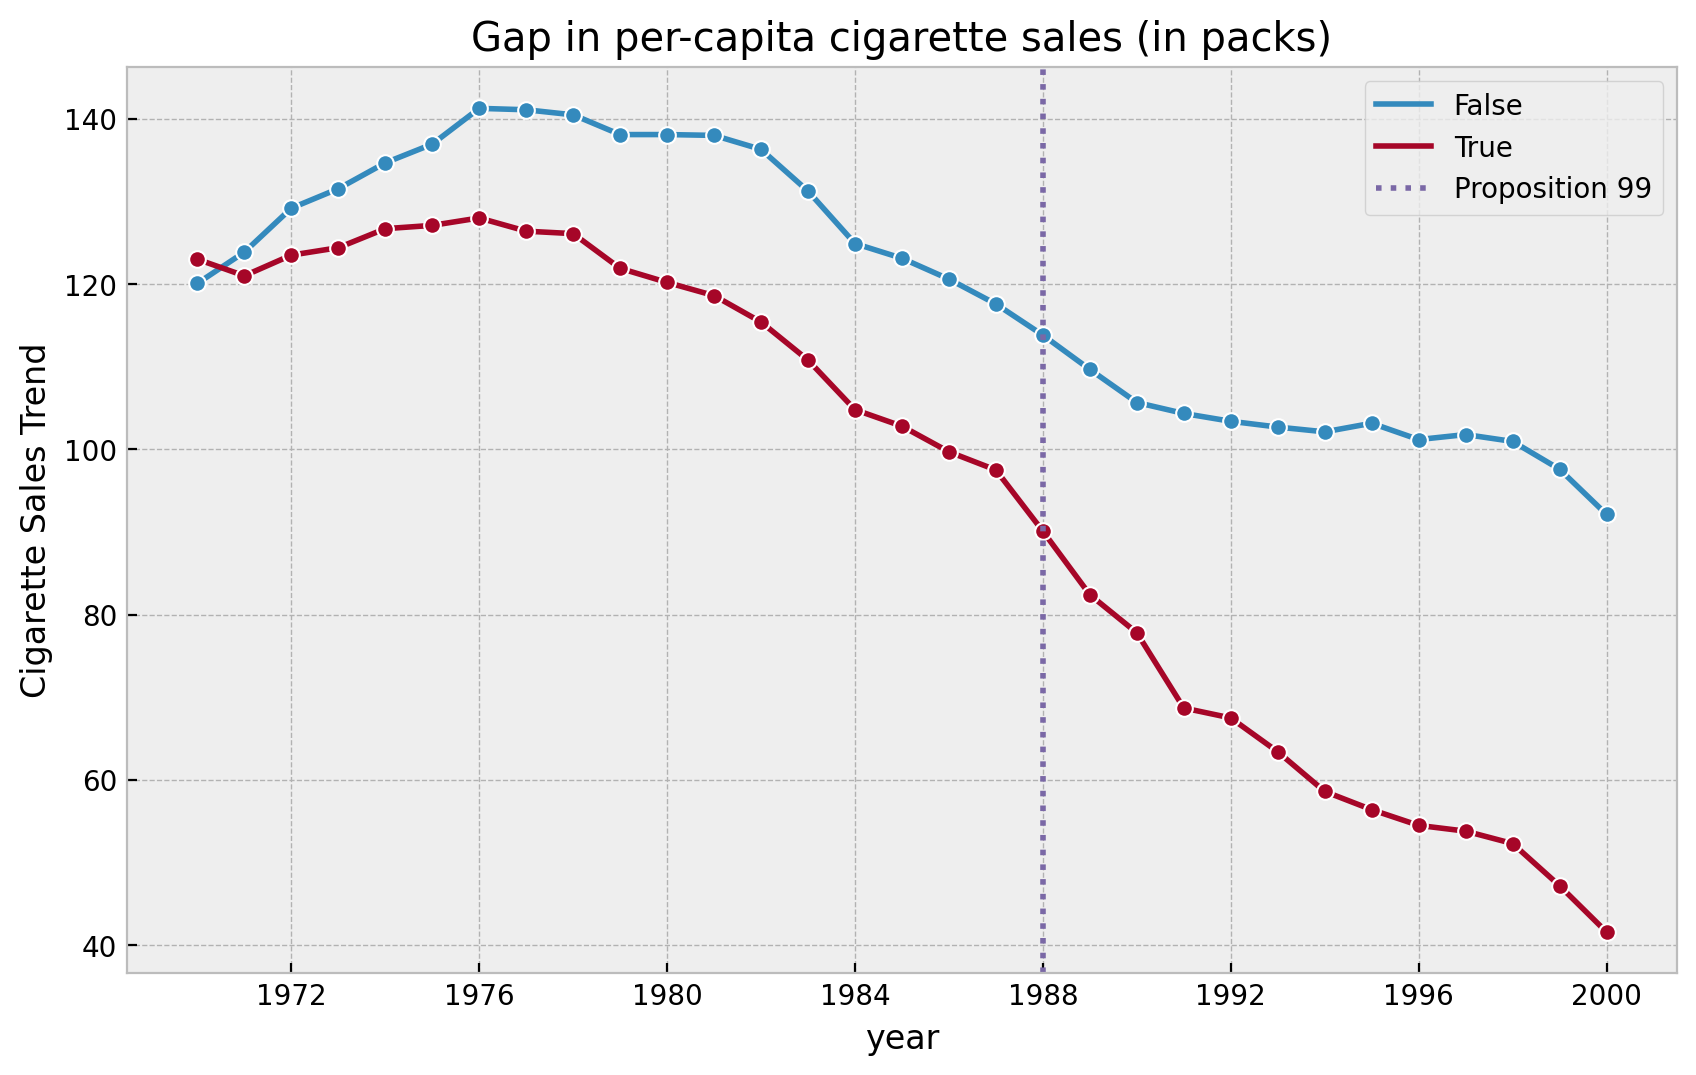

In [4]:
fig, ax = plt.subplots()

(
    df.groupby(["year", "california"], as_index=False)
    .agg({"cigsale": np.mean})
    .pipe(
        (sns.lineplot, "data"),
        x="year",
        y="cigsale",
        hue="california",
        marker="o",
        ax=ax,
    )
)
ax.axvline(
    x=pd.to_datetime("1988"),
    linestyle=":",
    lw=2,
    color="C2",
    label="Proposition 99",
)
ax.legend(loc="upper right")
ax.set(
    title="Gap in per-capita cigarette sales (in packs)", ylabel="Cigarette Sales Trend"
)


In [5]:
features = ["cigsale", "retprice"]

pre_df = (
    df
    .query("~ after_treatment")
    .pivot(index='state', columns="year", values=features)
    .T
)

post_df = (
    df
    .query("after_treatment")
    .pivot(index='state', columns="year", values=features)
    .T
)

In [6]:
y_pre = pre_df[3].to_numpy()
x_pre = pre_df.drop(columns=3).to_numpy()

y_post = post_df[3].to_numpy()
x_post = post_df.drop(columns=3).to_numpy()

In [7]:
k = pre_df.shape[0]

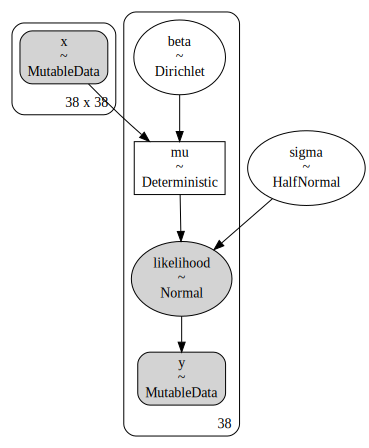

In [15]:
with pm.Model() as model:
    x = pm.MutableData(name="x", value=x_pre)
    y = pm.MutableData(name="y", value=y_pre)
    
    beta = pm.Dirichlet(name="beta", a=(1/k)*np.ones(k))
    sigma = pm.HalfNormal(name="sigma", sigma=5)
    mu = pm.Deterministic(name="mu", var=pm.math.dot(x, beta))
    likelihood = pm.Normal(name="likelihood", mu=mu, sigma=sigma, observed=y)

pm.model_to_graphviz(model)

In [16]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:03.571166
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:15.058150
Transforming variables...
Transformation time =  0:00:00.062848
Computing Log Likelihood...
Log Likelihood time =  0:00:00.160685


100.00% [16000/16000 00:01<00:00]

In [17]:
az.summary(data=idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.001,0.004,0.000,0.001,0.000,0.000,1876.0,1449.0,1.0
beta[1],0.000,0.003,0.000,0.001,0.000,0.000,1944.0,1279.0,1.0
beta[2],0.004,0.016,0.000,0.013,0.000,0.000,2327.0,2021.0,1.0
beta[3],0.005,0.017,0.000,0.025,0.000,0.000,2238.0,2369.0,1.0
beta[4],0.002,0.009,0.000,0.006,0.000,0.000,1625.0,1213.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[33],92.680,0.564,91.639,93.955,0.006,0.004,8906.0,11935.0,1.0
mu[34],100.327,0.718,98.784,101.808,0.009,0.006,6583.0,8451.0,1.0
mu[35],102.652,0.404,101.912,103.547,0.004,0.003,9309.0,11444.0,1.0
mu[36],111.003,0.478,109.819,111.759,0.009,0.007,4084.0,1709.0,1.0


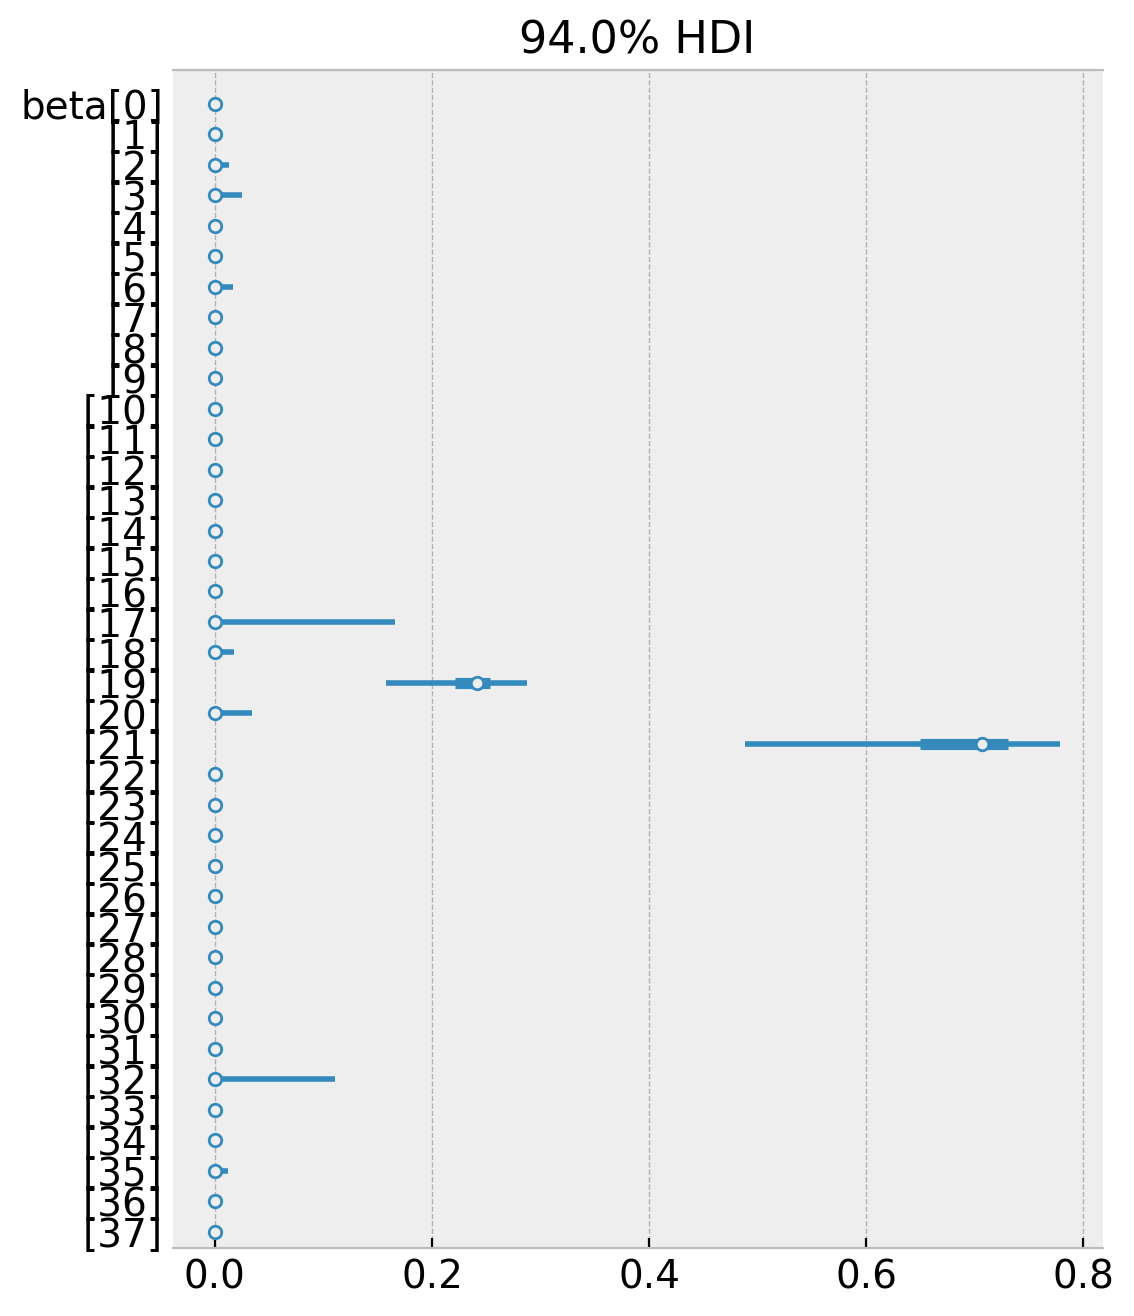

In [18]:
az.plot_forest(data=idata, combined=True, var_names=["beta"]);

In [19]:
idata.posterior["beta"].stack(samples=("chain", "draw")).sum(axis=0)

<xarray.DataArray 'beta' (samples: 16000)>
array([1., 1., 1., ..., 1., 1., 1.])
Coordinates:
 * samples (samples) object MultiIndex
 * chain (samples) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
 * draw (samples) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999 xarray.DataArray 'beta' samples : 16000 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 array([1., 1., 1., ..., 1., 1., 1.]) Coordinates: (3) samples (samples) object MultiIndex array([(0, 0), (0, 1), (0, 2), ..., (3, 3997), (3, 3998), (3, 3999)],
 dtype=object) chain (samples) int64 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 array([0, 0, 0, ..., 3, 3, 3]) draw (samples) int64 0 1 2 3 4 ... 3996 3997 3998 3999 array([ 0, 1, 2, ..., 3997, 3998, 3999]) Attributes: (0)

In [20]:
with model:
    pm.set_data(new_data={"x": x_post, "y": y_post})
    posterior_predictive_post = pm.sample_posterior_predictive(
        trace=idata, var_names=["likelihood"]
    )


100.00% [16000/16000 00:01<00:00]

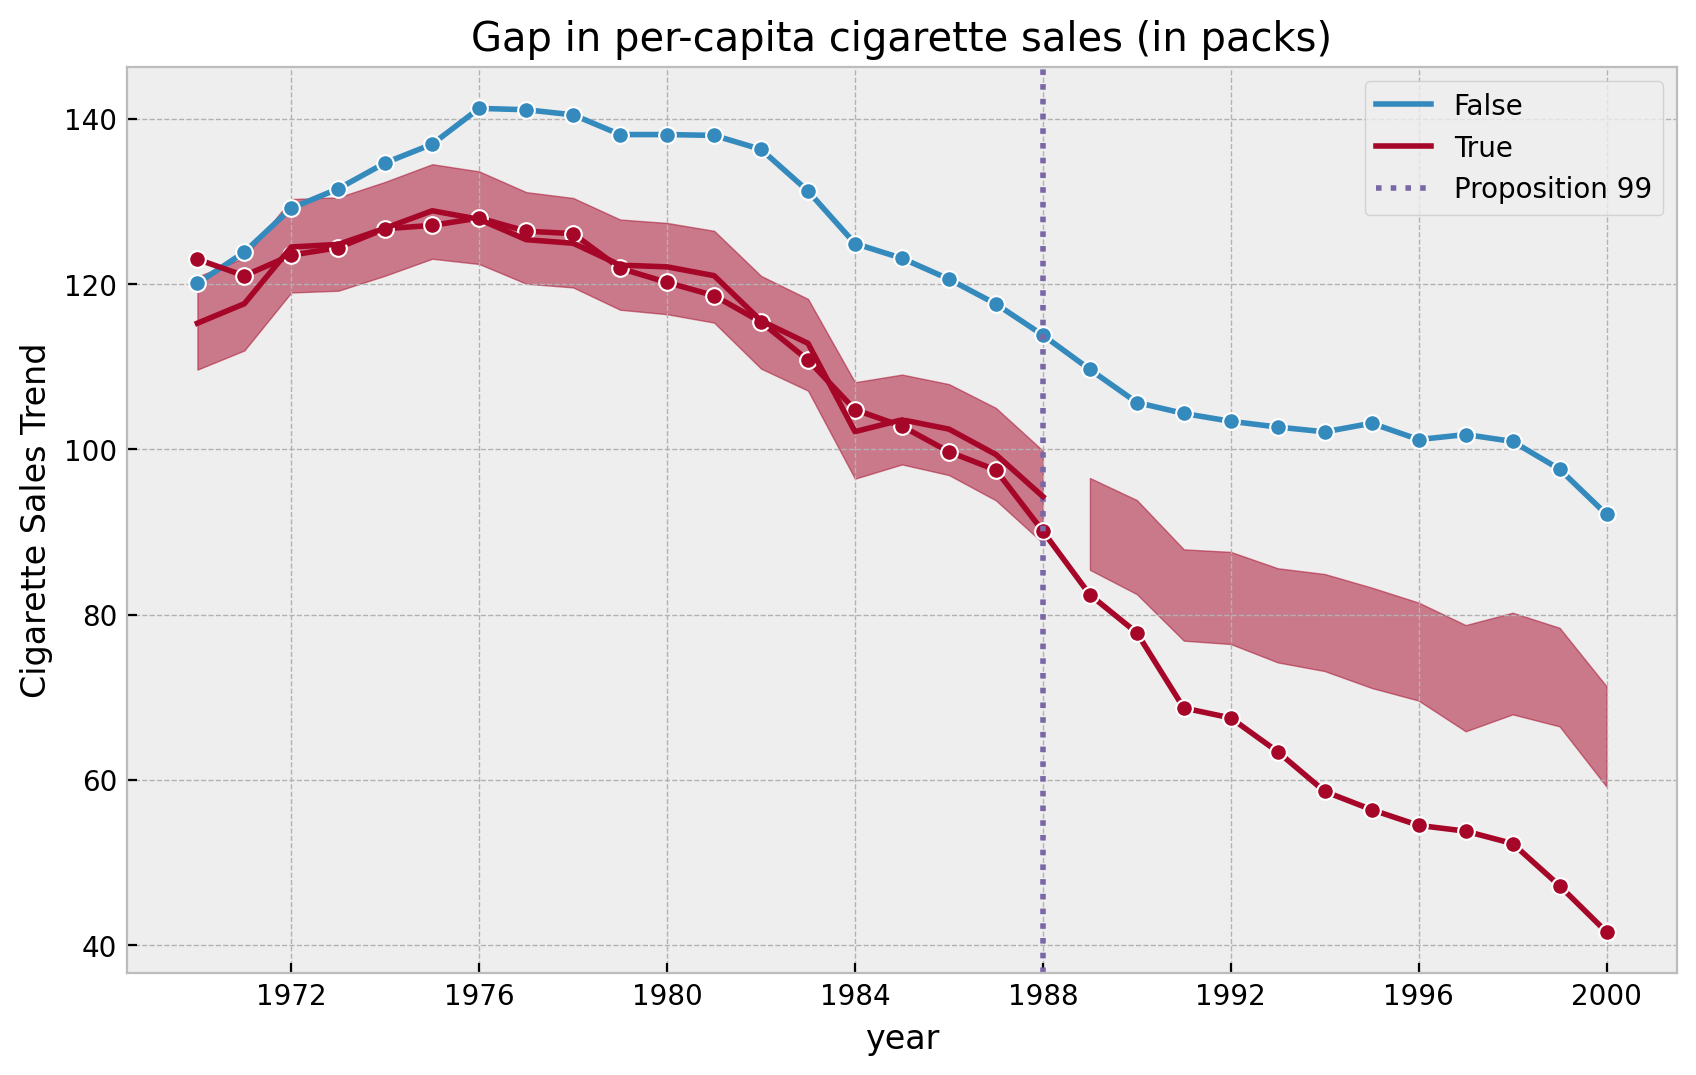

In [21]:
fig, ax = plt.subplots()

(
    df.groupby(["year", "california"], as_index=False)
    .agg({"cigsale": np.mean})
    .pipe(
        (sns.lineplot, "data"),
        x="year",
        y="cigsale",
        hue="california",
        marker="o",
        ax=ax,
    )
)
ax.axvline(
    x=pd.to_datetime("1988"),
    linestyle=":",
    lw=2,
    color="C2",
    label="Proposition 99",
)
ax.plot(
    df.query("(~ after_treatment) and california")["year"],
    posterior_predictive_pre.posterior_predictive["likelihood"][:, :, : 19].stack(samples=("chain", "draw")).mean(axis=1))

az.plot_hdi(
    x=df.query("(~ after_treatment) and california")["year"],
    y=posterior_predictive_pre.posterior_predictive["likelihood"][:, :, : 19],
    smooth=False
)
az.plot_hdi(
    x=df.query("(after_treatment) and california")["year"],
    y=posterior_predictive_post.posterior_predictive["likelihood"][:, :, : 12],
    smooth=False
)
ax.legend(loc="upper right")
ax.set(
    title="Gap in per-capita cigarette sales (in packs)", ylabel="Cigarette Sales Trend"
);
